# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

### Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST.
- Output shape (num_students, num_timesteps, num_asts). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps) Values are in range (0, num_asts)

Accuracy:
- Raw Accuracy: For all predictions at all timesteps, we get the percentage of predictions we got correct.
- Corrected Accuracy: Since many trajectories contain fewer asts than max_traj_len, we fill the empty asts with our dummy ast token at row 0. However, predicting on end tokens is to simple of a task and might bias our results. The corrected accuracy ignores all predictions on the end token.

### Current Issues:
    1. AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [1]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize

In [3]:
# Each trajectory matrix corresponds to one hoc exercise and is
# its own data set. Mixing data sets currently does not make much
# sense since the AST IDs don't persist betweeen different hoc's.
TRAJ_MAP = {
    'hoc1': '../processed_data/traj_matrix_1.npy',
    'hoc2': '../processed_data/traj_matrix_2.npy',
    'hoc3': '../processed_data/traj_matrix_3.npy',
    'hoc4': '../processed_data/traj_matrix_4.npy',
    'hoc5': '../processed_data/traj_matrix_5.npy',
    'hoc6': '../processed_data/traj_matrix_6.npy',
    'hoc7': '../processed_data/traj_matrix_7.npy',
    'hoc8': '../processed_data/traj_matrix_8.npy',
    'hoc9': '../processed_data/traj_matrix_9.npy' 
}

TRAJ_MAP_PREFIX = '../processed_data/traj_matrix_'
TRAJ_MAP_SUFFIX = '.npy'

HOC_NUM = str(7)
DATA_SET = 'hoc' + HOC_NUM
# if DATA_SZ = -1, use entire data set
# For DATA_SZ, powers of 2 work best for performance.
DATA_SZ = -1
AST_MAP_FILE = '../processed_data/map_ast_row_' + HOC_NUM + '.pickle'

In [5]:
# Load AST ID to Row Map
ast_id_to_row_map = pickle.load(open( AST_MAP_FILE, "rb" ))
# Create Row to AST ID Map by inverting the previous one
row_to_ast_id_map = {v: k for k, v in ast_id_to_row_map.items()}

In [6]:
# trajectories matrix for a single hoc exercise
# shape (num_traj, max_traj_len, num_asts)
# Note that ast_index = 0 corresponds to the <END> token,
# marking that the student has already finished.
# The <END> token does not correspond to an AST.
traj_mat = np.load(TRAJ_MAP[DATA_SET])
print traj_mat.shape
# print traj_mat[:10, :, :10]

(4195, 7, 432)


In [7]:
# if DATA_SZ specified, reduce matrix. 
# Useful to create smaller data sets for testing purposes.
if DATA_SZ != -1:
    traj_mat = traj_mat[:DATA_SZ]
print traj_mat.shape
# print traj_mat_sm[:, :, :10]

(4195, 7, 432)


In [8]:
# shuffle the first dimension of the matrix
np.random.shuffle(traj_mat)
# print traj_mat_sm[:, :, :10]

In [9]:
num_traj, max_traj_len, num_asts = traj_mat.shape
# Split data into train, val, test
# TODO: Replace with kfold validation in the future
# perhaps we can use sklearn kfold?

train_mat = traj_mat[0:7*num_traj/8,:]
val_mat =  traj_mat[7*num_traj/8: 15*num_traj/16 ,:]
test_mat = traj_mat[15*num_traj/16:num_traj,:]


In [10]:
print('Preparing network inputs and targets...')
# X_train, y_train = utils.prepare_traj_data_for_rnn(train_data)
# X_val, y_val = utils.prepare_traj_data_for_rnn(val_data)
# X_test, y_test = utils.prepare_traj_data_for_rnn(test_data)

train_data = utils.prepare_traj_data_for_rnn(train_mat)
val_data = utils.prepare_traj_data_for_rnn(val_mat)
test_data = utils.prepare_traj_data_for_rnn(test_mat)


X_train, y_train = train_data
X_val, y_val = val_data
X_test, y_test = test_data
print X_train.shape
print y_train.shape
print X_val.shape
print X_test.shape
num_train, num_timesteps, num_asts = X_train.shape

print y_train[:10]
print X_train[:10,:, :10]

X_train_ast_ids, y_train_ast_ids = utils.convert_data_to_ast_ids(train_data, row_to_ast_id_map)
print X_train_ast_ids[:10]
print y_train_ast_ids[:10]

print num_timesteps
print ("Inputs and targets done!")

Preparing network inputs and targets...
(3670, 6, 432)
(3670, 6)
(262, 6, 432)
(263, 6, 432)
[[   2.   43.    0.    0.    0.    0.]
 [  51.    3.    0.    0.    0.    0.]
 [  36.    2.   27.   28.    0.    0.]
 [  59.    1.    3.    0.    0.    0.]
 [   2.  322.    0.    0.    0.    0.]
 [   2.   27.    3.    0.    0.    0.]
 [  37.  108.    3.    0.    0.    0.]
 [   1.    3.    0.    0.    0.    0.]
 [ 219.   43.    0.    0.    0.    0.]
 [  30.   34.    3.    0.    0.    0.]]
[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.

In [11]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 2e-2
lr_decay = 0.995
reg_strength = 1e-2
grad_clip = 10
batchsize = 32
num_epochs = 10
dropout_p = 0.2
num_lstm_layers = 2
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [13]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


In [15]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 1140
Ep 0 	iter 1  	loss 5.71710, train acc 64.06, train corr acc 36.11, val acc 66.16, val corr acc 33.00
Ep 0 	iter 2  	loss 2.10251, train acc 68.75, train corr acc 34.78, val acc 66.16, val corr acc 33.00
Ep 0 	iter 3  	loss 1.99258, train acc 65.62, train corr acc 32.65, val acc 66.09, val corr acc 32.87
Ep 0 	iter 4  	loss 2.22885, train acc 65.62, train corr acc 32.65, val acc 66.16, val corr acc 33.00
Ep 0 	iter 5  	loss 2.32056, train acc 64.58, train corr acc 32.00, val acc 66.28, val corr acc 33.25
Ep 0 	iter 6  	loss 2.17487, train acc 59.90, train corr acc 29.36, val acc 66.67, val corr acc 34.01
Ep 0 	iter 7  	loss 2.22112, train acc 67.19, train corr acc 36.36, val acc 61.32, val corr acc 25.57
Ep 0 	iter 8  	loss 1.81876, train acc 64.06, train corr acc 29.90, val acc 65.84, val corr acc 32.37
Ep 0 	iter 9  	loss 1.53966, train acc 63.02, train corr acc 30.39, val acc 66.98, val corr acc 34.63
Ep 0 	iter 10  	loss 1.84297,

In [16]:
# Evaluate on test set
test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, row_to_ast_id_map, dataset_name='test')

Testing...
Final results:
  test loss:			1.107700
  test raw accuracy:		74.59 %
  test corrected accuracy:	51.04 %


In [17]:
# Convert to AST IDs so we can look at the AST json files
X_test_ast_ids, y_test_ast_ids = utils.convert_data_to_ast_ids(test_data, row_to_ast_id_map)
pred_test_ast_ids = utils.convert_pred_to_ast_ids(pred_test, row_to_ast_id_map)
print("X AST IDs")
print X_test_ast_ids[:10,:]
print ("Truth AST IDs")
print y_test_ast_ids[:10, :]
print("Predicted AST IDs")
print pred_test_ast_ids[:10,:]

X AST IDs
[[   1.   75.   29.   -1.   -1.   -1.]
 [  13.   74.    0.   -1.   -1.   -1.]
 [ 214.   14.   -1.   -1.   -1.   -1.]
 [   1.    8.    3.    0.   -1.   -1.]
 [   1.    3.    7.    9.   -1.   -1.]
 [   5.    1.    5.    0.   -1.   -1.]
 [  38.    1.   -1.   -1.   -1.   -1.]
 [   2.   27.    0.   -1.   -1.   -1.]
 [   1.    4.   11.    2.    0.   -1.]
 [ 498.    0.   -1.   -1.   -1.   -1.]]
Truth AST IDs
[[ 75.  29.  -1.  -1.  -1.  -1.]
 [ 74.   0.  -1.  -1.  -1.  -1.]
 [ 14.  -1.  -1.  -1.  -1.  -1.]
 [  8.   3.   0.  -1.  -1.  -1.]
 [  3.   7.   9.  -1.  -1.  -1.]
 [  1.   5.   0.  -1.  -1.  -1.]
 [  1.  -1.  -1.  -1.  -1.  -1.]
 [ 27.   0.  -1.  -1.  -1.  -1.]
 [  4.  11.   2.   0.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.]]
Predicted AST IDs
[[   4.   66.    0.   -1.   -1.   -1.]
 [  74.   27.   -1.   -1.   -1.   -1.]
 [   0.   -1.   -1.   -1.   -1.   -1.]
 [   4.    3.    0.   -1.   -1.   -1.]
 [   4.   11.    0.   -1.   -1.   -1.]
 [   3.    0.    0.   -1.   -1.   -1.]
 [

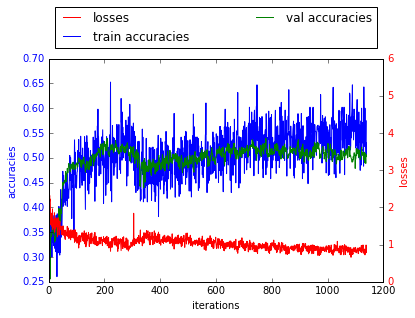

In [20]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
visualize.plot_loss_acc(DATA_SET + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')

Below are more trial runs

In [27]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.95
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 4
dropout_p = 0.2
num_lstm_layers = 2
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [25]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


In [26]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 912
Ep 0 	iter 1  	loss 6.06737, train acc 0.00, train corr acc 0.00, val acc 65.97, val corr acc 32.62
Ep 0 	iter 2  	loss 5.89079, train acc 68.75, train corr acc 34.78, val acc 66.16, val corr acc 33.00
Ep 0 	iter 3  	loss 4.46106, train acc 65.62, train corr acc 32.65, val acc 66.16, val corr acc 33.00
Ep 0 	iter 4  	loss 2.31920, train acc 65.62, train corr acc 32.65, val acc 66.16, val corr acc 33.00
Ep 0 	iter 5  	loss 1.96573, train acc 64.58, train corr acc 32.00, val acc 66.16, val corr acc 33.00
Ep 0 	iter 6  	loss 2.29655, train acc 59.90, train corr acc 29.36, val acc 66.09, val corr acc 32.87
Ep 0 	iter 7  	loss 2.37445, train acc 64.58, train corr acc 31.31, val acc 66.16, val corr acc 33.00
Ep 0 	iter 8  	loss 1.81655, train acc 66.15, train corr acc 32.99, val acc 66.16, val corr acc 33.00
Ep 0 	iter 9  	loss 1.74316, train acc 63.54, train corr acc 31.37, val acc 66.98, val corr acc 34.63
Ep 0 	iter 10  	loss 2.11811, tr

KeyboardInterrupt: 

In [30]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 456
Ep 0 	iter 1  	loss 0.97781, train acc 75.00, train corr acc 55.56, val acc 75.83, val corr acc 52.14
Ep 0 	iter 2  	loss 0.85359, train acc 78.65, train corr acc 55.43, val acc 75.51, val corr acc 51.51
Ep 0 	iter 3  	loss 0.97043, train acc 76.04, train corr acc 53.06, val acc 75.06, val corr acc 50.63
Ep 0 	iter 4  	loss 0.97060, train acc 74.48, train corr acc 50.00, val acc 75.70, val corr acc 51.89
Ep 0 	iter 5  	loss 0.99557, train acc 74.48, train corr acc 51.00, val acc 75.51, val corr acc 51.51
Ep 0 	iter 6  	loss 0.97527, train acc 73.44, train corr acc 53.21, val acc 75.70, val corr acc 51.89
Ep 0 	iter 7  	loss 0.94274, train acc 75.00, train corr acc 51.52, val acc 75.51, val corr acc 51.51
Ep 0 	iter 8  	loss 0.95586, train acc 74.48, train corr acc 49.48, val acc 76.02, val corr acc 52.52
Ep 0 	iter 9  	loss 0.87428, train acc 76.56, train corr acc 55.88, val acc 76.34, val corr acc 53.15
Ep 0 	iter 10  	loss 1.06246, 